In [62]:
import pymc3 as pm
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as ss
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, confusion_matrix
from statsmodels.formula.api import ols, logit, glm

import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

# Heirarchical Models

In [2]:
import scipy.stats as ss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Mean 2.4960578853217075
Pr[>1] 0.773262


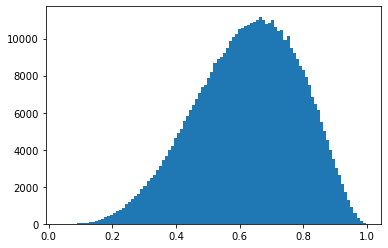

In [3]:
rv = ss.beta(a=5, b=3)
ps = rv.rvs(size=int(5e5))
odds = ps / (1 - ps)
print('Mean', np.mean(odds))
print('Pr[>1]', np.mean(odds>1))
_ = plt.hist(ps, bins=100)

# Random Walk and Markov Chain

In [3]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np

In [4]:
rv = ss.norm(loc=0, scale=1)
ps = rv.rvs(size=int(5e5))
np.quantile(ps, 0.3)

-0.5227833935495759

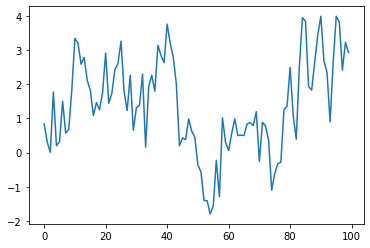

In [5]:
np.random.seed(123123)
rv = ss.norm(loc=0, scale=1)
plt.plot(np.cumsum(rv.rvs(size=100)))

# Metropolis-Hasting Algo

In [170]:
import scipy.stats as ss
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

In [171]:
def metropolis_rw(n_iter, init_x, gfunc, qscale):
    """
    Random Walk Metropolis Hasting Sampling Algorithm
    that assumes symmetric normal proposal distribution

    parameter
    ---------
    n_iter: number of iteration that generates n samples
    init_x: initial x guess to start the calculation
    gfunc: the function g(x) that is porpotional to the target distribution P(x)
    """
    samples = []
    accept = 0
    qfunc = ss.norm
    x0 = init_x

    for _ in range(int(n_iter)):
        x1 = qfunc(loc=x0, scale=qscale).rvs()
        alpha = gfunc(x1) - gfunc(x0)  # make sure it on log scale

        if np.random.random() < np.exp(alpha):
            x0 = x1
            accept += 1

        samples.append(x0)
    return samples, accept/n_iter


def log_tg(mu, n, ybar):
    """
    the function g(x) that is porpotional to the target distribution P(x)
    under ln(.) scale
    """
    mu2 = mu ** 2
    return n * (ybar*mu - mu2/2) - np.log(1+mu2)

0.6442


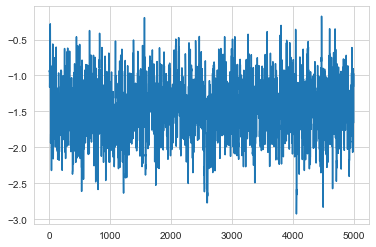

In [184]:
np.random.seed(23124)

# data = [1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9]
data = [-0.2, -1.5, -5.3, 0.3, -0.8, -2.2]
n, ybar = len(data), np.mean(data)
gfunc = lambda x: log_tg(x, n, ybar)
samples, acc_pct = metropolis_rw(n_iter=5000, init_x=0, gfunc=gfunc, qscale=0.5)

plt.plot(samples)
print(acc_pct)

In [185]:
az.summary(np.array(samples))

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-1.458,0.413,-2.243,-0.719,0.015,0.011,748.0,779.0,NaN


<AxesSubplot:ylabel='Count'>

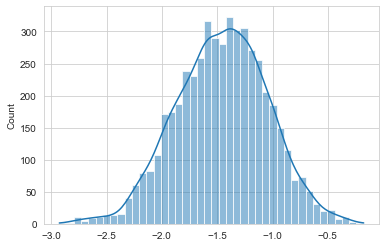

In [174]:
sns.histplot(samples, kde=True)

# Gibbs Sampling

In [90]:
import scipy.stats as ss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [78]:
def update_mu(n, ybar, sig2, mu_0, sig2_0):
    sig2_1 = 1.0 / (n / sig2 + 1.0 / sig2_0)
    mu_1 = sig2_1 * (n * ybar / sig2 + mu_0 / sig2_0)
    return ss.norm.rvs(loc=mu_1, scale=np.sqrt(sig2_1), size=1)


def update_sig2(n, y, mu, nu_0, beta_0):
    nu_1 = nu_0 + n / 2.0
    sumsq = np.sum((y - mu)**2)  # vectorized
    beta_1 = beta_0 + sumsq / 2.0
    out_gamma = ss.gamma.rvs(a=nu_1, scale=1/beta_1, size=1)  # rate for gamma is shape for inv-gamma
    return 1.0 / out_gamma  # reciprocal of a gamma random variable is distributed inv-gamma


def gibbs(y, n_iter, init_mu, prior):
    ybar = np.mean(y)
    n = len(y)

    # initialize
    mu_out = []
    sig2_out = []

    mu_now = init_mu

    # Gibbs sampler
    for i in range(1, int(n_iter)+1):
        sig2_now = update_sig2(n=n, y=y, mu=mu_now, nu_0=prior['nu_0'], beta_0=prior['beta_0'])
        mu_now = update_mu(n=n, ybar=ybar, sig2=sig2_now, mu_0=prior['mu_0'], sig2_0=prior['sig2_0'])
        sig2_out.append(sig2_now)
        mu_out.append(mu_now)

    return pd.DataFrame(np.c_[mu_out, sig2_out], columns=['mu', 'sig2'])

In [168]:
np.random.seed(53)

# y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9])
y = np.array([-0.2, -1.5, -5.3, 0.3, -0.8, -2.2])
ybar = np.mean(y)
n = len(y)

init_mu = 0

## prior
prior = {
    'mu_0': 1,
    'sig2_0': 1,
    'n_0': 2, # prior effective sample size for sig2
    's2_0': 1, # prior point estimate for sig2
}
prior['nu_0'] = prior['n_0'] / 2.0 # prior parameter for inverse-gamma
prior['beta_0'] = prior['n_0'] * prior['s2_0'] / 2.0 # prior parameter for inverse-gamma

post = gibbs(y=y, n_iter=5000, init_mu=init_mu, prior=prior)

In [169]:
post.describe()

,mu,sig2
count,5000.000000,5000.000000
mean,-0.494365,5.558102
std,0.744031,4.696634
min,-2.673004,0.851973
25%,-1.013120,2.898744
50%,-0.552438,4.286523
75%,-0.027077,6.516087
max,2.652125,70.696051


<AxesSubplot:>

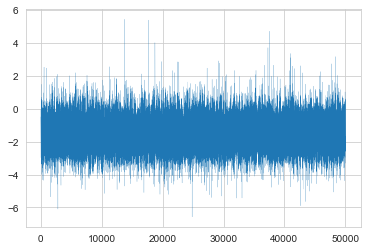

In [167]:
post.mu.plot(linewidth=0.15)

In [111]:
post.sig2.autocorr()

0.2243599564778422

In [117]:
post.mu.autocorr(3)

0.012750416336907242

In [125]:
az.summary(post.mu.to_numpy())

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-0.494,0.744,-1.829,0.931,0.013,0.009,3205.0,3768.0,NaN


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

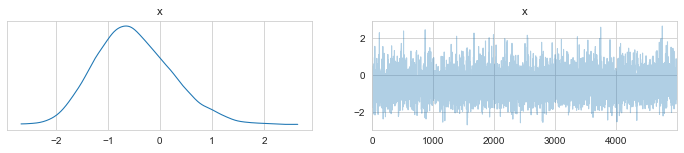

In [132]:
az.plot_trace(post.mu.to_numpy())

# PYMC3 & Theano Implementation

In [118]:
import pymc3 as pm
import numpy as np
import arviz as az

In [186]:
data = [1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9]

basic_model = pm.Model()
with basic_model:
    mu = pm.StudentT('mu', nu=1, mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=data)

In [188]:
pm.find_MAP(model=basic_model)

{'mu': array(0.89066666, dtype=float32)}

In [217]:
with basic_model:
    res = pm.sample(10000, chains=4, tune=5000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 27 seconds.


In [218]:
az.summary(res)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.898,0.31,0.311,1.477,0.002,0.002,19042.0,28985.0,1.0


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

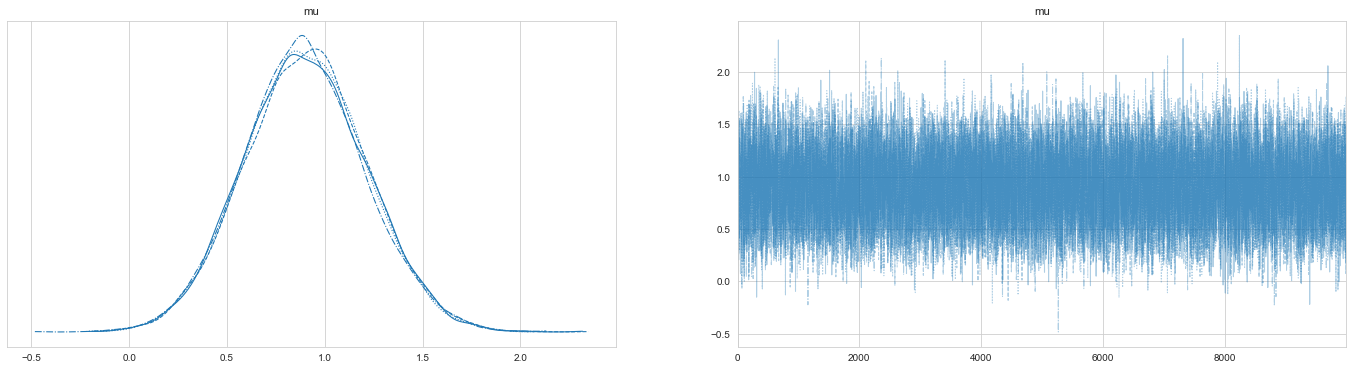

In [219]:
az.plot_trace(res, figsize=(24,6), kind='trace')

array([<AxesSubplot:title={'center':'mu\n0'}>,
       <AxesSubplot:title={'center':'mu\n1'}>,
       <AxesSubplot:title={'center':'mu\n2'}>,
       <AxesSubplot:title={'center':'mu\n3'}>], dtype=object)

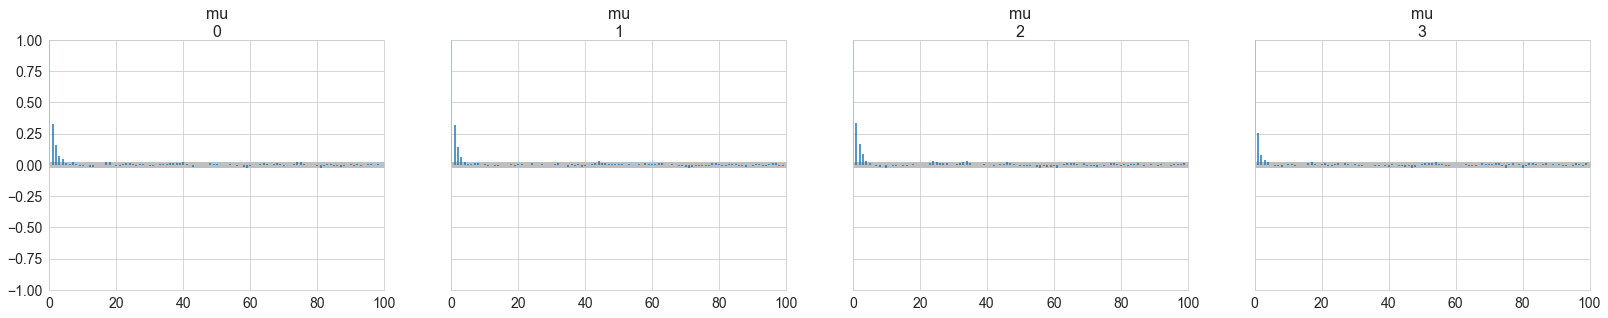

In [220]:
az.plot_autocorr(res)

# Leinhardt Dataset OLS

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import statsmodels.api as sm

import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [44]:
leinh = pd.read_csv('Leinhardt.csv', index_col=[0])
leinh = leinh[~leinh.isna().any(1)]

X = sm.add_constant(np.log(leinh['income']))
y = np.log(leinh['infant'])

<AxesSubplot:xlabel='income', ylabel='infant'>

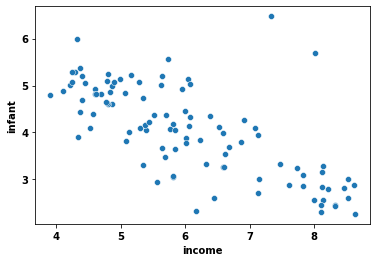

In [53]:
sns.scatterplot(x=np.log(leinh.income), y=np.log(leinh.infant))

In [54]:
ols_model = sm.OLS(y, X)
res = ols_model = ols_model.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.497   
Dependent Variable: infant           AIC:                212.6845
Date:               2021-10-29 14:37 BIC:                217.9148
No. Observations:   101              Log-Likelihood:     -104.34 
Df Model:           1                F-statistic:        99.84   
Df Residuals:       99               Prob (F-statistic): 1.14e-16
R-squared:          0.502            Scale:              0.47157 
-------------------------------------------------------------------
           Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const      7.1458     0.3165   22.5748   0.0000    6.5177    7.7739
income    -0.5118     0.0512   -9.9922   0.0000   -0.6134   -0.4102
-----------------------------------------------------------------
Omnibus:             38.668       Durbin-Watson:          1.898  
Prob(Omnibus):       0.000        Jarque-Bera (JB):       129.408
Skew:                1.255        Prob(JB):               0.000  
Kurtosis:            7.945        Condition No.:          29     
=================================================================

"""

In [60]:
x = np.log(leinh.income)
y = np.log(leinh.infant)

with pm.Model() as model:
    sigma = pm.InverseGamma('sigma', alpha=5/2, beta=5*10/2)
    b0 = pm.Normal('b0', 0, sigma=1e6)
    b1 = pm.Normal('b1', 0, sigma=1e6)

    y_hat = pm.Normal('y_hat', mu=b0 + b1*x, sigma=sigma, observed=y)

In [64]:
with model:
    bres = pm.sample(draws=10000, chains=4, tune=5000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1, b0, sigma]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 32 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8852253360214334, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.89283871180399, but should be close to 0.8. Try to increase the number of tuning steps.


In [65]:
az.summary(bres)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,7.146,0.382,6.428,7.857,0.003,0.002,12708.0,14163.0,1.0
b1,-0.512,0.062,-0.632,-0.400,0.001,0.000,12743.0,13662.0,1.0
sigma,0.819,0.063,0.705,0.940,0.000,0.000,16646.0,11010.0,1.0


array([[<AxesSubplot:title={'center':'b0'}>,
        <AxesSubplot:title={'center':'b0'}>],
       [<AxesSubplot:title={'center':'b1'}>,
        <AxesSubplot:title={'center':'b1'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

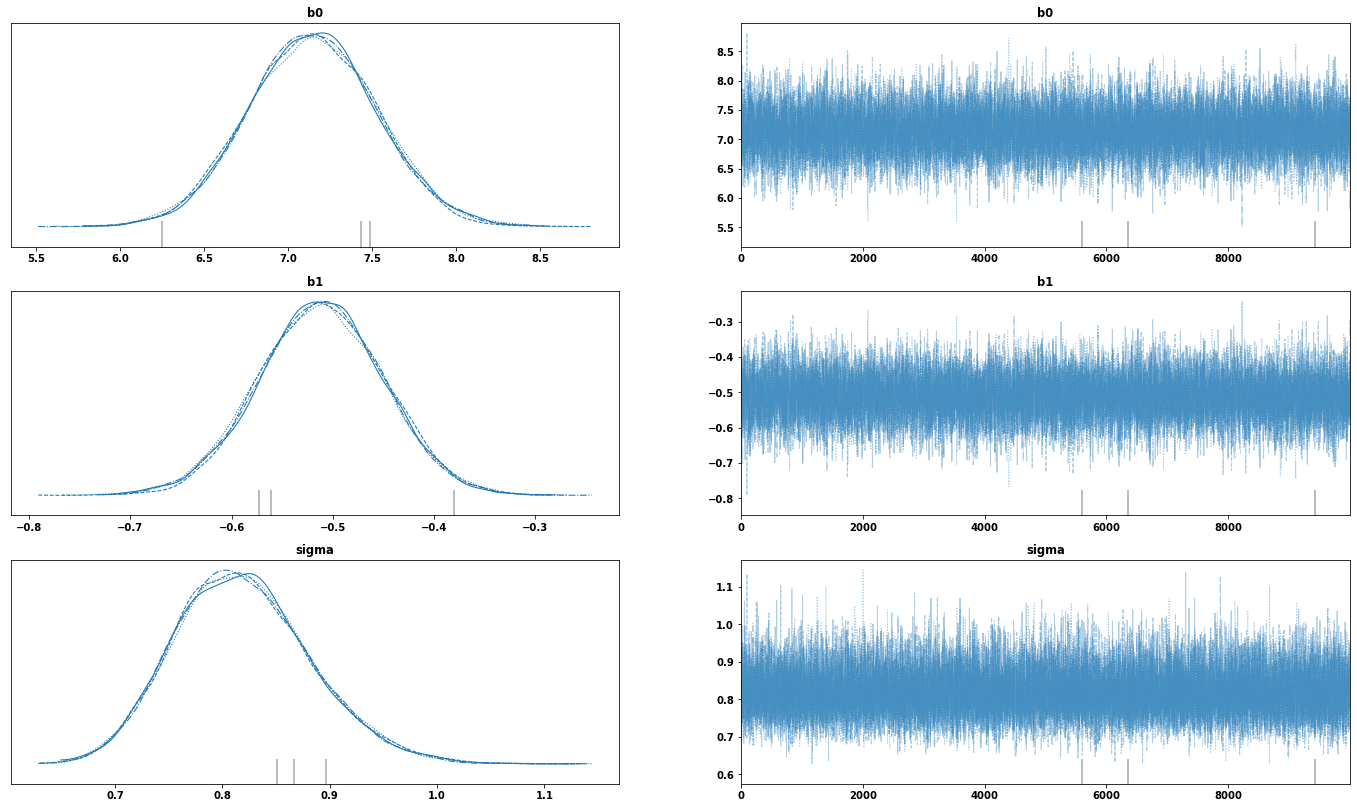

In [69]:
az.plot_trace(bres, figsize=(24,14))

# Anscombe OLS

In [63]:
anscombe = sm.datasets.get_rdataset('Anscombe', 'carData').data

In [4]:
y = anscombe.education
X = sm.add_constant(anscombe[['income', 'young', 'urban']])

res = sm.OLS(y, X).fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.670   
Dependent Variable: education        AIC:                483.5767
Date:               2021-10-29 17:12 BIC:                491.3040
No. Observations:   51               Log-Likelihood:     -237.79 
Df Model:           3                F-statistic:        34.81   
Df Residuals:       47               Prob (F-statistic): 5.34e-12
R-squared:          0.690            Scale:              712.54  
------------------------------------------------------------------
          Coef.    Std.Err.     t     P>|t|     [0.025     0.975] 
------------------------------------------------------------------
const   -286.8388   64.9199  -4.4183  0.0001  -417.4408  -156.2367
income     0.0807    0.0093   8.6738  0.0000     0.0619     0.0994
young      0.8173    0.1598   5.1151  0.0000     0.4959     1.1388
urban     -0.1058    0.0343  -3.0863  0.0034    -0.1748    -0.0368
-----------------------------------------------------------------
Omnibus:              0.074        Durbin-Watson:           1.919
Prob(Omnibus):        0.964        Jarque-Bera (JB):        0.212
Skew:                 0.079        Prob(JB):                0.900
Kurtosis:             2.727        Condition No.:           58352
=================================================================
* The condition number is large (6e+04). This might indicate
strong multicollinearity or other numerical problems.
"""

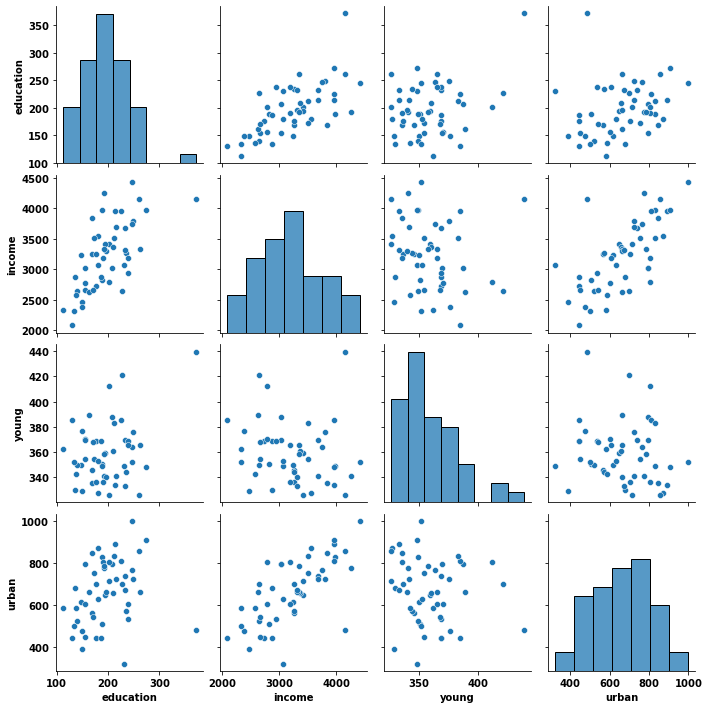

In [91]:
sns.pairplot(anscombe)

In [88]:
X = anscombe[['income', 'young', 'urban']]
X = (X - X.mean(0)) / X.std(0)  # normalize
y = anscombe['education']
y = (y - y.mean()) / y.std()  # normalize

with pm.Model() as model:
    betas = []
    mu = 0
    for col_nm, feature in X.iteritems():
        beta = pm.Laplace(col_nm, 0, 1)
        betas.append(beta)
        mu += beta * feature
    
    sigma = pm.InverseGamma('sigma', alpha=1/2, beta=1/2)
    y_hat = pm.Normal('Education', mu=mu, sigma=sigma, observed=y)
    
    # print(pm.find_MAP())
    bres = pm.sample(10000, chains=3, tune=1500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, urban, young, income]


Sampling 3 chains for 1_500 tune and 10_000 draw iterations (4_500 + 30_000 draws total) took 20 seconds.


In [89]:
az.summary(bres)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
income,0.950,0.114,0.735,1.165,0.001,0.001,17086.0,19239.0,1.0
young,0.413,0.084,0.255,0.571,0.001,0.000,26393.0,20959.0,1.0
urban,-0.323,0.114,-0.546,-0.116,0.001,0.001,16519.0,18433.0,1.0
sigma,0.580,0.061,0.470,0.695,0.000,0.000,22488.0,17228.0,1.0


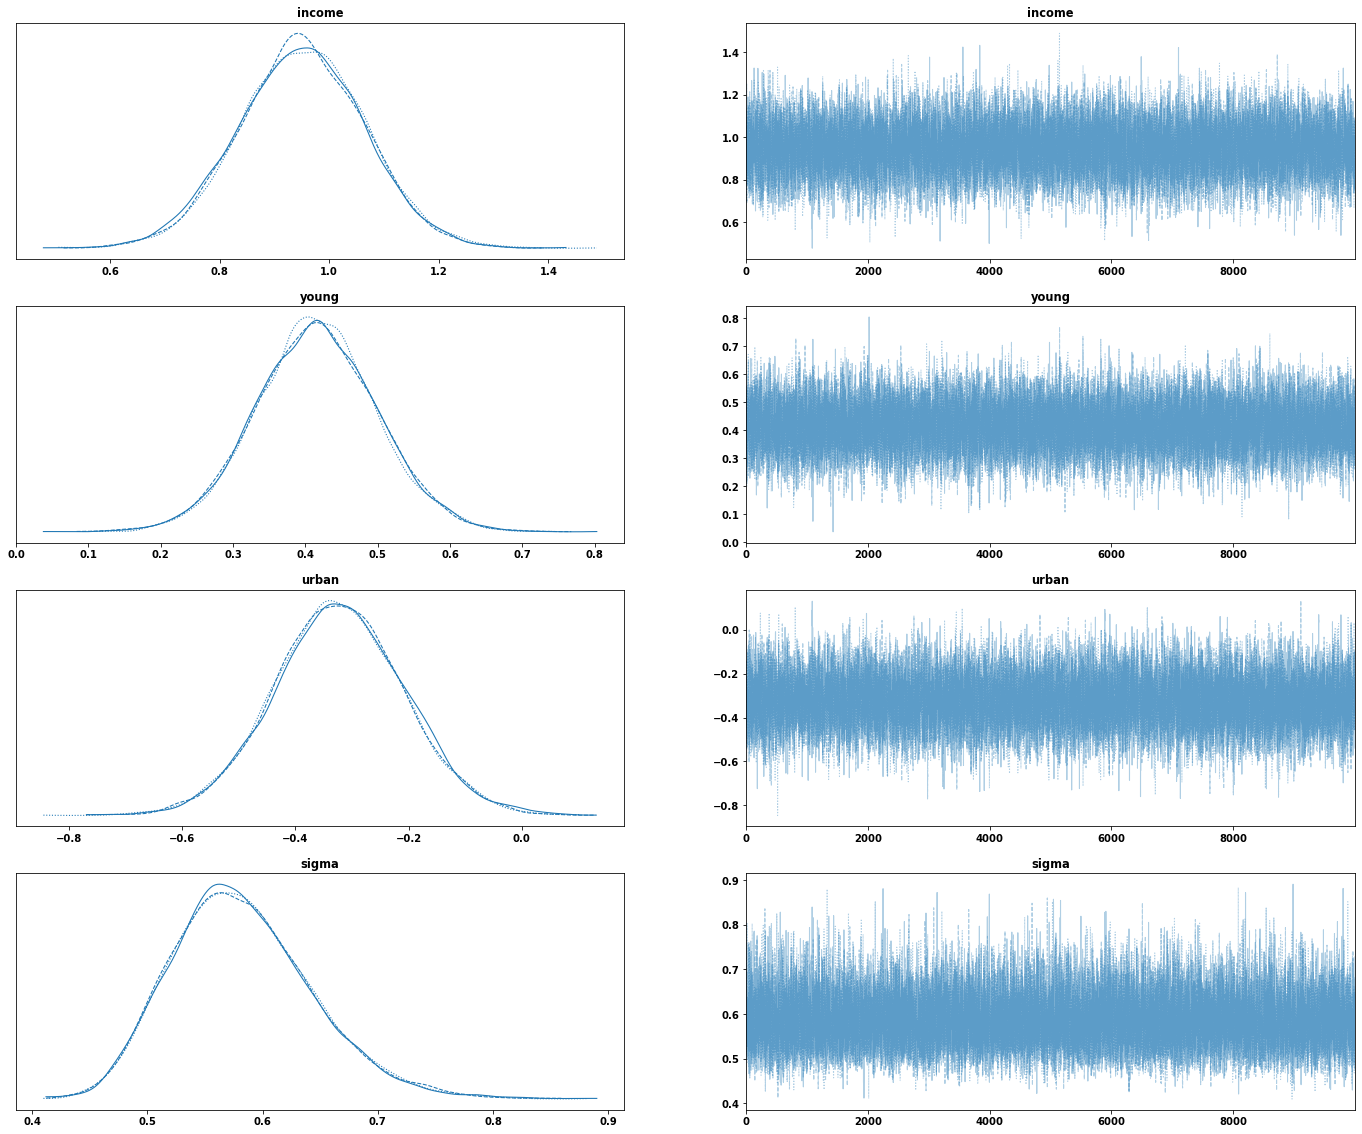

In [87]:
_ = az.plot_trace(bres, figsize=(24,20))